# Lab 08: Black Box AI - Neural Networks & Computer Vision

## Introduction

In Lab 07, we used models like Decision Trees, Random Forests, and XGBoost to predict the state of a piece of toast (`Under-done`, `Perfect`, `Burnt`) based on structured data (e.g., `ToastingTime`, `BreadThickness`).

In this lab, we then go further into "Black Box" AI—specifically, **Neural Networks**. For details please check the lecture slides.

We will:
1.  **Apply a Multi-Layer Perceptron (MLP)** to our familiar Lab 07 "toaster" dataset.
2.  **Build a simple MLP from scratch** using NumPy to understand its inner workings (feedforward, backpropagation).
3.  **Use a pre-trained YOLO model**, a powerful Convolutional Neural Network (CNN), to perform real-time object detection on images, e.g. "Can it find a toaster?"
4.  **Final Challenge: Build and optimize your own CNN** to solve a new image classification problem: detecting food on a real dataset!

## Submission
1.  This is a **group assignment**. One submission per group.
2.  You can work in **Google Colab** or **locally** (recommended) .
3.  Complete all tasks in this notebook.
4.  For the **Final Challenge**, you must finish the first report and run the cells to generate `txt` format reports. Fill in and generate report 2 and 3 only if you choose to do optional job step 3.5.
5.  Submit forked Github repository link to canvas.

## Setup: Install Virtual Environment and Libraries

**Tips**: Before install PyTorch, please verify your operation system to see if they have GPU or CPU only. For Macbook with Apple Silicon, you may consider you have MPS as neural network processing unit to replace NVIDIA GPU.

You are required to create a new **virtual environment**, and install the following libraries:

    torch, torchvision (They require special attention. Please help check `### PyTorch Installation Guide`)

    opencv-python, tqdm, numpy, pandas, seaborn, matplotlib, scikit-learn, ultralytics

### PyTorch Installation Guide

Pick specific Pytorch (torch, torchvision) for your own system, especially if you have GPU with CUDA enabled, and python version with reference from [General installation guide for all platforms](https://pytorch.org/get-started/locally/).

**For NVIDIA GPU Users (CUDA):**
- [CUDA Toolkit Installation](https://developer.nvidia.com/cuda-downloads)
- Check CUDA compatibility: `nvidia-smi` in terminal
- [Multiple CUDA Compilation](https://github.com/siyanhu/MultipleCUDA)

**For Apple Silicon (MPS):**
- PyTorch automatically supports MPS on newer Macs
- Install PyTorch for Mac: `pip3 install torch torchvision`
- [PyTorch MPS Guide](https://pytorch.org/docs/stable/notes/mps.html)

**For CPU-only Systems:**
- Use CPU-compatible PyTorch: `pip install torch torchvision`

## **Part 1: The Multi-Layer Perceptron (MLP) on Structured Data**

Let's start by revisiting our Lab 07 toaster dataset. An MLP is a "universal function approximator" and should be able to learn the complex, non-linear boundaries between `Under-done`, `Perfect`, and `Burnt`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# --- Regenerate the Lab 07 Toaster Data ---
np.random.seed(42)

def generate_toaster_data_interactive(n_samples=5000):
    # Feature Generation
    toasting_time = np.random.randint(60, 500, n_samples)
    bread_thickness = np.random.uniform(5, 30, n_samples)
    is_frozen = np.random.randint(0, 2, n_samples)
    ambient_temp = np.random.normal(20, 6, n_samples)

    # Non-linear ideal_time (Same as Lab 07)
    base_ideal_time = (30 + 1.5 * bread_thickness + 0.1 * bread_thickness**2 + 0.005 * bread_thickness**3)
    frozen_penalty = is_frozen * (base_ideal_time * (np.exp(0.04 * bread_thickness) - 1))
    unadjusted_ideal_time = base_ideal_time + frozen_penalty
    temp_efficiency_factor = np.exp(0.025 * (ambient_temp - 20))
    ideal_time = unadjusted_ideal_time / temp_efficiency_factor

    perfect_window_width = 25 + bread_thickness
    time_diff_sq = (toasting_time - ideal_time)**2
    perfect_score = np.exp(-time_diff_sq / (2 * perfect_window_width**2))

    burn_onset_offset = 45
    burn_rate_k = 0.1
    time_past_ideal = toasting_time - ideal_time - burn_onset_offset
    burnt_score = 1 / (1 + np.exp(-burn_rate_k * time_past_ideal))

    perfect_score += np.random.normal(0, 0.3, n_samples)
    burnt_score += np.random.normal(0, 0.3, n_samples)

    toast_state = np.zeros(n_samples, dtype=int) # 0: Under-done
    is_perfect = (perfect_score > burnt_score) & (perfect_score > 0.6)
    toast_state[is_perfect] = 1 # 1: Perfect
    is_burnt = (burnt_score > perfect_score) & (burnt_score > 0.5)
    toast_state[is_burnt] = 2 # 2: Burnt

    df = pd.DataFrame({
        'ToastingTime': toasting_time,
        'BreadThickness': bread_thickness,
        'IsFrozen': is_frozen,
        'AmbientTemp': ambient_temp,
        'ToastState': toast_state
    })
    return df

df = generate_toaster_data_interactive()
print("Toaster data (Lab 07) loaded:")
print(df.head())

# --- Prepare Data for ML ---
X = df.drop('ToastState', axis=1)
y = df['ToastState']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# **IMPORTANT for Neural Networks**:
# Scale the features. NNs are sensitive to feature scale.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nData prepared: {X_train_scaled.shape[0]} training samples, {X_test_scaled.shape[0]} test samples.")

Toaster data (Lab 07) loaded:
   ToastingTime  BreadThickness  IsFrozen  AmbientTemp  ToastState
0           162       11.785964         1    15.258515           0
1           495        8.133912         1    23.953351           2
2           408       13.424118         0    14.178307           2
3           330       29.988598         0    12.165528           1
4           166       15.143779         0    23.922013           2

Data prepared: 3500 training samples, 1500 test samples.


### Task 1.1: Train a `scikit-learn` MLP

Let's use the pre-built `MLPClassifier` from `scikit-learn` to understand the difference among a MLP deep learning network, and previous XGBoost/Random Forest from Lab07.

1.  Import `MLPClassifier` from `sklearn.neural_network`.
2.  Initialize it. A good starting point is `hidden_layer_sizes=(100, 50)`, which means two hidden layers with 100 and 50 neurons, respectively. Use `max_iter=500` to give it enough time to train, and `random_state=42` for reproducibility.
3.  Fit the model on the **scaled** training data (`X_train_scaled`, `y_train`).
4.  Predict on the **scaled** test data (`X_test_scaled`).
5.  Print the accuracy and the classification report.
6.  **Question:** Rerun the final challenge in Lab07, how does this accuracy compare to the best model you submitted (e.g., XGBoost or Random Forest)?

    **TODO:**  * My accuracy is 0.866,the MLP's is 0.876*

7. **Challenge:** Beat the baseline accuracy. Try a few different hyperparameter settings, record the results, and write down your answers in the following table.

    | Experiment | Example | What to Test | Your Settings | Accuracy | Notes |
    |------------|---------------|--------------|---------------|----------|-------|
    | Wider Network | e.g. `(200, 150)` | Impact of more neurons per layer | [200,50] | [fill] | [your notes] |
    | Strong Regularization | e.g. `alpha=0.01` | Effect on overfitting | [0.001] | [fill] | [your notes] |
    | SGD Solver | e.g. `solver='sgd'` | Different optimization algorithm | [solver=sgd] | [fill] | [your notes] |
    | Different number of Layers | e.g. single layer `(200,)` | Different network architecture | [200] | [fill] | [your notes] |
    | Learning Rate | e.g. `learning_rate_init=0.01` | Faster/slower convergence | [learning_rate_init=0.01] | [fill] | [your notes] |

In [2]:
from sklearn.neural_network import MLPClassifier

# 1. Initialize the MLPClassifier
# (100, 50) means 2 hidden layers: one with 100 neurons, one with 50.
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, 
                        activation='relu', solver='adam', alpha=0.001)

# 2. Fit the model
print("Training the scikit-learn MLP...")
mlp_clf.fit(X_train_scaled, y_train)
print("Training complete.")

# 3. Predict on the test set
y_pred_mlp = mlp_clf.predict(X_test_scaled)

# 4. Evaluate the model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
report_mlp = classification_report(y_test, y_pred_mlp, target_names=['Under-done', 'Perfect', 'Burnt'])

print(f"\n--- scikit-learn MLP Results ---")
print(f"Accuracy: {accuracy_mlp:.4f}")
print("Classification Report:")
print(report_mlp)

Training the scikit-learn MLP...


/Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Training complete.

--- scikit-learn MLP Results ---
Accuracy: 0.8760
Classification Report:
              precision    recall  f1-score   support

  Under-done       0.86      0.77      0.81       456
     Perfect       0.76      0.76      0.76       205
       Burnt       0.91      0.96      0.94       839

    accuracy                           0.88      1500
   macro avg       0.84      0.83      0.84      1500
weighted avg       0.87      0.88      0.87      1500



/Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


### Task 1.2: Build a Simple MLP with PyTorch

Now that you've used the `scikit-learn` helper, let's build the same model using PyTorch. This is a great way to learn PyTorch's workflow, which we'll use again in Part 3 for our CNN.

**Our Goal:** Re-create the MLP classifier from Task 1.1 using PyTorch.

**Your Task:**
1. Complete the missing layers in `PyTorchMLP` class
2. **Add learning rate scheduling** to the training loop
3. **Implement early stopping** based on validation loss
4. **Visualize training progress** with loss/accuracy plots
5. Compare your results with at least one different optimizers (Adam, SGD etc)

Using device: cpu
PyTorch DataLoaders created.

Training PyTorch MLP...
Learing rate0.001 is passed
learing rate0.001 have a better performance than 0.0
Learning rate9 's loss is greater than 0.4 in epoch20
Learning rate0.01 's loss is greater than 0.4 in epoch20
Learning rate0.1 's loss is greater than 0.4 in epoch20
Best learning rate is 0.001
Learing rate0.001,Epoch [20/100], Loss: 0.2707
Learing rate0.001,Epoch [40/100], Loss: 0.3870
Learing rate0.001,Epoch [60/100], Loss: 0.5116
Learing rate0.001,Epoch [80/100], Loss: 0.3488
Learing rate0.001,Epoch [100/100], Loss: 0.3823
Training complete.

--- PyTorch MLP Results ---
Accuracy: 0.8747
Classification Report:
              precision    recall  f1-score   support

  Under-done       0.88      0.75      0.81       456
     Perfect       0.74      0.76      0.75       205
       Burnt       0.90      0.97      0.93       839

    accuracy                           0.87      1500
   macro avg       0.84      0.83      0.83      1500
we

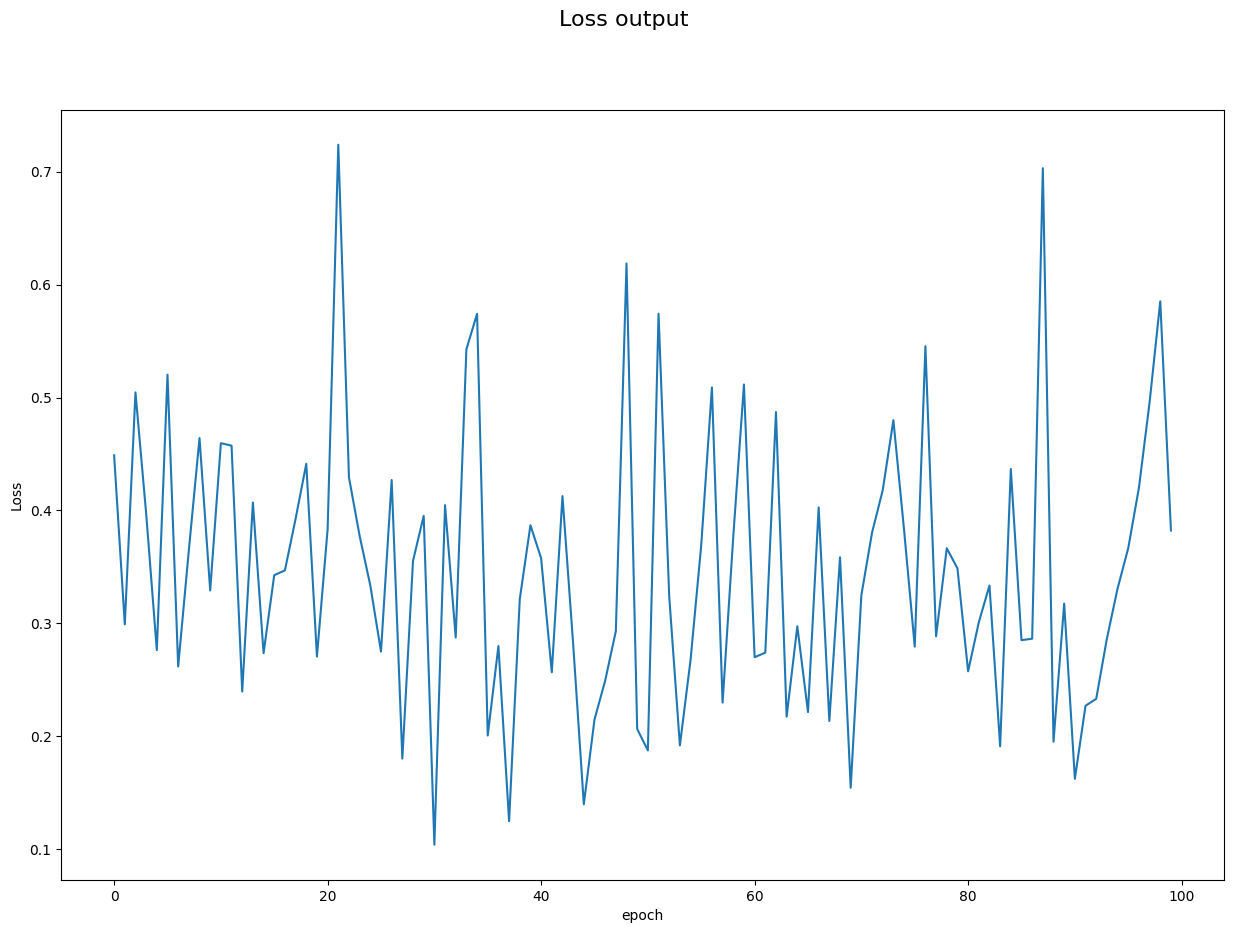

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Define the PyTorch MLP Model ---
class PyTorchMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(PyTorchMLP, self).__init__()
        # --- TODO: Define the layers ---
        # We want: Input -> 100 neurons -> ReLU -> 50 neurons -> ReLU -> Output (3 neurons)
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(nn.Linear(input_size,100),nn.ReLU(),nn.Linear(100,50),nn.ReLU(),nn.Linear(50,output_size))
        # ---------------------------------

    def forward(self, x):
        # --- TODO: Define the forward pass ---
        x=self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        # ---------------------------------

# --- 2. Prepare Data for PyTorch ---

# Check if a GPU (like in Colab) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device) # CrossEntropyLoss expects long integers for labels
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch DataLoaders created.")

# Create Figure
fig,ax=plt.subplots(figsize=(15,10))
fig.suptitle('Loss output',fontsize=16)
epochr=[]
lossrate=[]
losssum=0.0
losssum_pre=10000

# --- 3. Initialize Model, Loss, and Optimizer ---
n_input = X_train_scaled.shape[1]
n_output = len(np.unique(y_train))

# pytorch_mlp = PyTorchMLP(n_input, n_output).to(device)
# criterion = nn.CrossEntropyLoss() # This loss function includes Softmax!
# optimizer = optim.Adam(pytorch_mlp.parameters(), lr=0.001)

# --- 4. Training Loop ---
epochs = 100 # scikit-learn's default is 200, but Adam is fast
print("\nTraining PyTorch MLP...")

#Record the lowest loss learning rate 
Best_lr=0.0
#Inplement the learning rate loop
for lra in [1e-3,13-4,1e-2,1e-1]:
    pytorch_mlp = PyTorchMLP(n_input, n_output).to(device)
    criterion = nn.CrossEntropyLoss() # This loss function includes Softmax!
    optimizer = optim.Adam(pytorch_mlp.parameters(), lr=lra)
    for epoch in range(epochs):
        pytorch_mlp.train() # Set model to training mode
        for inputs, labels in train_loader:
            # Forward pass
            outputs = pytorch_mlp(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 20 == 0:
            #print(f'Learing rate{lra},Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            #Early Validation
            if(loss.item()>0.5):
                losssum=0.0
                print(f"Learning rate{lra} 's loss is greater than 0.4 in epoch{epoch+1}")
                break

        #Sum the whole loss to compare the the accuracy.
        losssum+=loss.item()
        #replace and contain the best lr
        if epoch+1 == 100:
            print(f"Learing rate{lra} is passed")
            if losssum<=losssum_pre:
                losssum_pre=losssum
                print(f"learing rate{lra} have a better performance than {Best_lr}")
                Best_lr=lra
            losssum=0.0                
    

print(f"Best learning rate is {Best_lr}")

#Train the best model
pytorch_mlp = PyTorchMLP(n_input, n_output).to(device)
criterion = nn.CrossEntropyLoss() # This loss function includes Softmax!
optimizer=optim.Adam(pytorch_mlp.parameters(), lr=Best_lr)
for epoch in range(epochs):
        pytorch_mlp.train() # Set model to training mode
        for inputs, labels in train_loader:
            # Forward pass
            outputs = pytorch_mlp(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 20 == 0:
            print(f'Learing rate{Best_lr},Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
                #append list value for matplot
        epochr.append(epoch)
        lossrate.append(loss.item())
print("Training complete.")

# --- 5. Evaluate the Model ---
pytorch_mlp.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for efficiency
    for inputs, labels in test_loader:
        outputs = pytorch_mlp(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the index (class) with the highest score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy_pytorch = accuracy_score(all_labels, all_preds)
report_pytorch = classification_report(all_labels, all_preds, target_names=['Under-done', 'Perfect', 'Burnt'])

print(f"\n--- PyTorch MLP Results ---")
print(f"Accuracy: {accuracy_pytorch:.4f}")
print("Classification Report:")
print(report_pytorch)

print(f"\nCompare to scikit-learn's MLP accuracy: {accuracy_mlp:.4f}")

# --- TODO: Visualize your results: accuracy and runtime ---

ax.plot(epochr,lossrate)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
plt.show()
#print(accuracy_pytorch)


# ---------------------------------

In [4]:
# --- TODO: Do some experiments with different optimizers: training loop and inference ---
#print(accuracy_pytorch)
pytorch_mlp = PyTorchMLP(n_input, n_output).to(device)
criterion = nn.CrossEntropyLoss() # This loss function includes Softmax!
optimizer = optim.AdamW(pytorch_mlp.parameters(), lr=0.01)

for epoch in range(epochs):
        pytorch_mlp.train() # Set model to training mode
        for inputs, labels in train_loader:
            # Forward pass
            outputs = pytorch_mlp(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
pytorch_mlp.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for efficiency
    for inputs, labels in test_loader:
        outputs = pytorch_mlp(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the index (class) with the highest score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy_pytorch_wad = accuracy_score(all_labels, all_preds)
report_pytorch_wad = classification_report(all_labels, all_preds, target_names=['Under-done', 'Perfect', 'Burnt'])

print(f"\n--- PyTorch MLP Results ---")
print(f"Accuracy: {accuracy_pytorch_wad:.4f}")
print("Classification Report:")
print(report_pytorch_wad)
print(f"\nCompare to Pytorch MLP Adam accuracy: {accuracy_pytorch:.4f}")



# ---------------------------------


--- PyTorch MLP Results ---
Accuracy: 0.8687
Classification Report:
              precision    recall  f1-score   support

  Under-done       0.89      0.75      0.81       456
     Perfect       0.71      0.77      0.74       205
       Burnt       0.90      0.96      0.93       839

    accuracy                           0.87      1500
   macro avg       0.83      0.82      0.83      1500
weighted avg       0.87      0.87      0.87      1500


Compare to Pytorch MLP Adam accuracy: 0.8747


---

## **Part 2: Object Detection with YOLO**

Now we move from structured data to **unstructured data (images)**.

As the lecture explained, MLPs are not good for images. We need [**Convolutional Neural Networks (CNNs)**](https://github.com/vzhou842/cnn-from-scratch). 

[**YOLO (You Only Look Once)**](https://github.com/ultralytics/ultralytics) is a famous, fast, and accurate CNN-based model for **object detection**.

Object detection is harder than classification. Instead of just saying "This is an image of a cat," it says, "There is a cat at *these* coordinates [x, y, w, h]."

We will use the `ultralytics` library, which makes it very easy to load and use a pre-trained YOLOv8 model.

**Your Task:**
1.  Load the pre-trained `'yolov8n.pt'` model.
2.  Run the model on the `sample_image_urls` provided. One image has many objects which could be classificed into umbrella, sign, car...
3.  Display the results.
4.  **Find your own image which contain multiple objects of different classes** on the internet, provide the **URL** (not local file path), and run the model on it. Does it work?


In [5]:
from pathlib import Path

def find_images_with_pathlib(folder_dir: str, recursive: bool = True):
    """
    Finds all image files in a given folder using the pathlib module.

    Args:
        folder_dir (str): The path to the folder to search.
        recursive (bool): If True, searches subfolders as well. Defaults to True.

    Returns:
        list[str]: A list of absolute paths to the found image files.
    """
    image_files = []
    
    # Define the set of image file extensions to look for.
    # Using a set for efficient membership testing.
    image_extensions = {".jpg", ".jpeg", ".png", ".webp"}

    try:
        # Create a Path object for the given directory
        folder_path = Path(folder_dir)
        
        # Determine which iterator to use based on the 'recursive' flag
        if recursive:
            # path.rglob('*') recursively finds all files and directories
            path_iterator = folder_path.rglob('*')
        else:
            # path.glob('*') finds files and directories only in the top level
            path_iterator = folder_path.glob('*')

        # Loop through all the paths found by the iterator
        for file_path in path_iterator:
            # Check if the path is a file and its extension is in our set
            if file_path.is_file() and file_path.suffix.lower() in image_extensions:
                # If it's an image file, add its absolute path to our list
                image_files.append(str(file_path.resolve()))
                
    except FileNotFoundError:
        print(f"Error: The directory '{folder_dir}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
    return image_files

Loading YOLOv8n model...
Model loaded.

--- Running prediction on: /Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/data1/test_banana.jpeg ---

image 1/1 /Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/data1/test_banana.jpeg: 416x640 1 banana, 32.6ms
Speed: 1.0ms preprocess, 32.6ms inference, 5.6ms postprocess per image at shape (1, 3, 416, 640)
Detections:
  - Found 'banana' with 77.97% confidence.


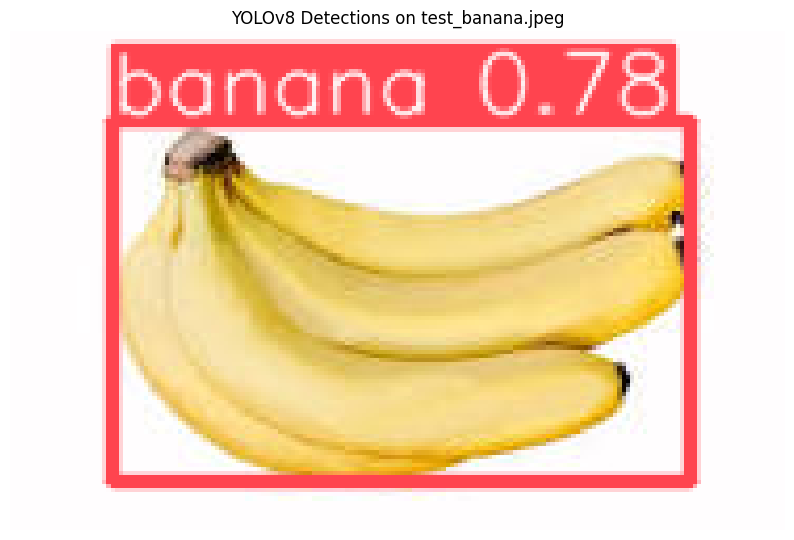


--- Running prediction on: /Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/data1/test_edamame.jpeg ---

image 1/1 /Users/koil/Library/CloudStorage/OneDrive-HKUSTConnect/ISDN 3000C/ISDN3000C_Lab08_template/data1/test_edamame.jpeg: 640x640 1 banana, 39.8ms
Speed: 1.5ms preprocess, 39.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Detections:
  - Found 'banana' with 39.30% confidence.


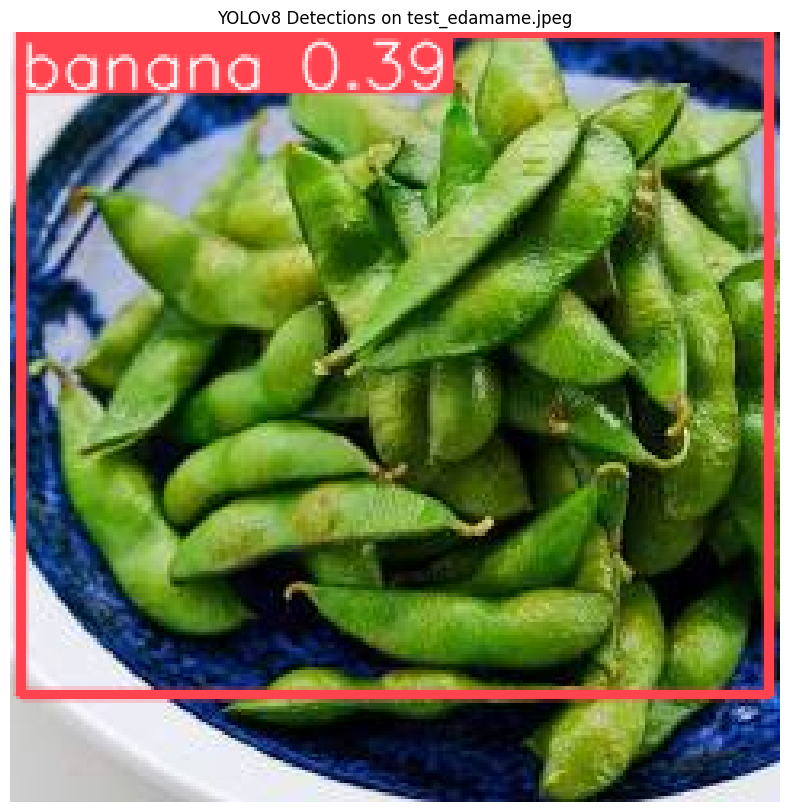

In [6]:
from ultralytics import YOLO
from matplotlib import pyplot as plt

# 1. Load the pre-trained YOLOv8n model (n = 'nano', the smallest version)
print("Loading YOLOv8n model...")
yolo_model = YOLO('yolov8n.pt')
print("Model loaded.")

# 2. Define sample image URLs
sample_image_urls = find_images_with_pathlib("./data1", recursive=True)

# 3. Run prediction on the sample images
for url in sample_image_urls:
    print(f"\n--- Running prediction on: {url} ---")
    # Run prediction directly from the URL
    results = yolo_model.predict(url)
    
    # Get the first result object
    res = results[0]
    
    # Print what it found
    print("Detections:")
    for box in res.boxes:
        class_id = int(box.cls)
        class_name = yolo_model.names[class_id]
        confidence = float(box.conf)
        print(f"  - Found '{class_name}' with {confidence*100:.2f}% confidence.")

    # Plot the image with bounding boxes
    # This creates a numpy array of the image with boxes drawn on it
    res_plotted = res.plot()
    
    # Display the image
    # Convert BGR (from OpenCV) to RGB (for Matplotlib)
    plt.figure(figsize=(10, 10))
    plt.imshow(res_plotted[..., ::-1]) 
    plt.axis('off')
    plt.title(f"YOLOv8 Detections on {url.split('/')[-1]}")
    plt.show()


#### Task 2.1: Test YOLO on Your Own Image

Go to Google Images, find picture of some objects, copy the image address, and paste it below. See if YOLO can find it!

In [7]:
# --- TODO: Test YOLOv8n on your own images, and visualize them ---
from ultralytics import YOLO
import requests 
from matplotlib import pyplot as plt

# 1. Load the pre-trained YOLOv8n model (n = 'nano', the smallest version)
print("Loading YOLOv8n model...")
yolo_model = YOLO('yolov8n.pt')
print("Model loaded.")


# 2. Define sample image URLs
sample_image_urls = find_images_with_pathlib("https://static.scientificamerican.com/dam/m/4beab95014486f06/original/Tree-Swallow2.JPG?m=1714055470.635&w=1350", recursive=False)

# 3. Run prediction on the sample images
for url in sample_image_urls:
    print(f"\n--- Running prediction on: {url} ---")
    # Run prediction directly from the URL
    results = yolo_model.predict(url)
    
    # Get the first result object
    res = results[0]
    
    # Print what it found
    print("Detections:")
    for box in res.boxes:
        class_id = int(box.cls)
        class_name = yolo_model.names[class_id]
        confidence = float(box.conf)
        print(f"  - Found '{class_name}' with {confidence*100:.2f}% confidence.")

    # Plot the image with bounding boxes
    # This creates a numpy array of the image with boxes drawn on it
    res_plotted = res.plot()
    
    # Display the image
    # Convert BGR (from OpenCV) to RGB (for Matplotlib)
    plt.figure(figsize=(10, 10))
    plt.imshow(res_plotted[..., ::-1]) 
    plt.axis('off')
    plt.title(f"YOLOv8 Detections on {url.split('/')[-1]}")
    plt.show()


# ---------------------------------

Loading YOLOv8n model...
Model loaded.


#### Task 2.2: Webcam Inference

Create a real-time food classification system using your webcam. For the way to use Webcam as an input, please check opencv document [OpenCV: Get Started with Videos](https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html).

Loading YOLOv8n model...
Model loaded.

0: 384x640 3 persons, 32.7ms
Speed: 1.3ms preprocess, 32.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Detections:
  - Found 'person' with 83.56% confidence.
  - Found 'person' with 55.31% confidence.
  - Found 'person' with 39.39% confidence.


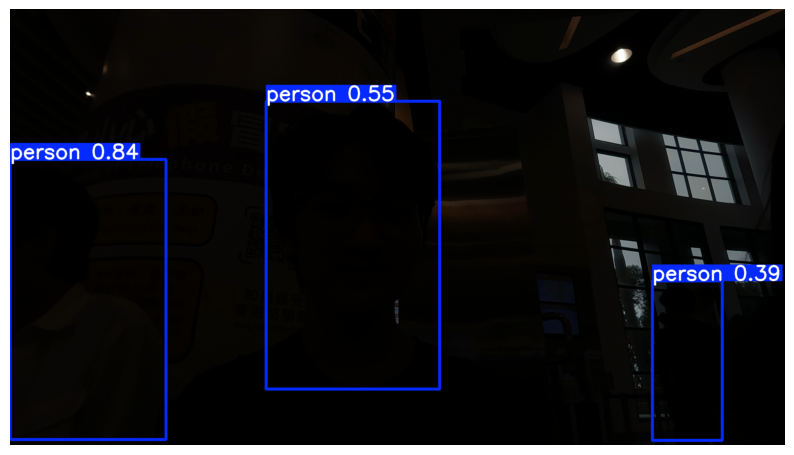

In [39]:
# --- TODO: Test YOLOv8n with your webcam, and visualize the results ---
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2 as cv 

print("Loading YOLOv8n model...")
yolo_model = YOLO('yolov8n.pt')
print("Model loaded.")

cap=cv.VideoCapture(0)
try:
    ret,frame=cap.read()
except:
    print("Webcom opens unsuccessfully")


# 2. Define sample image URLs

url=frame
results = yolo_model.predict(url)

# Get the first result object
res = results[0]

# Print what it found
print("Detections:")
for box in res.boxes:
    class_id = int(box.cls)
    class_name = yolo_model.names[class_id]
    confidence = float(box.conf)
    print(f"  - Found '{class_name}' with {confidence*100:.2f}% confidence.")

# Plot the image with bounding boxes
# This creates a numpy array of the image with boxes drawn on it
res_plotted = res.plot()

# Display the image
# Convert BGR (from OpenCV) to RGB (for Matplotlib)
plt.figure(figsize=(10, 10))
plt.imshow(res_plotted[..., ::-1]) 
plt.axis('off')
plt.show()
cap.release()


# ---------------------------------

---

## **Part 3: Final Challenge - Food Image Classification CNN**

### Overview
In this final challenge, we will build a **CNN Classifier** from scratch to classify food images. We'll use the **Food-101 dataset** (a public dataset with 101 food categories) and demonstrate:

1. **CNN Architecture Design** - A custom CNN optimized for food classification
2. **Data Pipeline** - Image loading, augmentation, and preprocessing
3. **Training & Validation** - Full training loop with early stopping and model checkpointing
4. **Evaluation & Inference** - Performance metrics and visualization
5. **Optimization Techniques** - Data augmentation, learning rate scheduling, and regularization

### Dataset Information
- **Food\-101 Dataset**: 101 food categories with ~1000 images per class
- **Total Images**: ~101,000 images (split: 75,750 training, 25,250 test)
- **Image Size**: Typically 512x512 or can be resized to 224x224 for efficiency
- **Access**: Can be downloaded via `torchvision` or Kaggle

For this exercise, we'll work with a **subset of the dataset** to ensure it runs on local CPU/GPU.

### **Step 3.1: Dataset Setup - Food-101 Dataset**

**⚠️Attention⚠️:** You will need at least 15 GB storage space to run through the whole process. If you don't have enough space on your machine, please connect an external drive and set the MACRO `DATA_DIR` to your own dataset location.

**1.  Set up File configuration**

In [13]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import time
from tqdm import tqdm
from pathlib import Path


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")

# Dataset configuration. For Google Colab users, you may find it at Google Drive, mounted as /content/drive/MyDrive/ etc.
DATA_DIR = "./data"
DATASET_NAME = "Food-101"
IMG_SIZE = 224  # Resizing all images to 224x224 for efficiency
NUM_CLASSES = 101

folder_path = Path(DATA_DIR)
if folder_path.exists():
    if not folder_path.is_dir():
        raise Exception(" The existing path is not a directory") 
else:
    folder_path.mkdir()
    print(f"The  directory \"{folder_path.name}\" is not existing and it is created now")
print(f"The directory \"{folder_path.name}\" is ready")
            

Using device: mps
The directory "data" is ready


**2.  Define data transforms (preprocessing and augmentation)**

In [14]:
# Training transforms: includes augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Test/Validation transforms: no augmentation
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**3.  Prepare Dataset and DataLoader**

In [15]:
import os


# Create data directory if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)

print("Downloading Food-101 dataset... (This may take a few minutes on first run)")
print("Dataset size: ~4-5 GB")



# Download and load Food-101 dataset
print("Loading training data...")

train_dataset = datasets.Food101(
    root=DATA_DIR, 
    split='train', 
    transform=train_transforms,
    download=False
)

print("Loading test data...")
test_dataset = datasets.Food101(
    root=DATA_DIR, 
    split='test', 
    transform=test_transforms,
    download=False
)

print(f"\nDataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes[:10]}... (showing first 10)")

Dataset size: ~4-5 GB
Loading training data...
Loading test data...

Dataset loaded successfully!
Training samples: 75750
Test samples: 25250
Number of classes: 101
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']... (showing first 10)


**Attention:** if you have access to a device with GPU (CUDA installed), you may proceed with the full dataset of Food-101 for training. Otherwise, please estimate training time here:

In [16]:
print(f"\nEstimated training time:")

if str(device) == 'cpu':
    est_sec_per_batch = 0.5  # Rough estimate for CPU
    est_time_per_epoch = len(train_loader) * est_sec_per_batch
    est_total_time_30_epochs = est_time_per_epoch * 30

    print(f"  Device: CPU")
    print(f"  Per batch: ~{est_sec_per_batch:.1f} sec")
    print(f"  Per epoch: ~{est_time_per_epoch:.0f} sec (~{est_time_per_epoch/60:.1f} min)")
    print(f"  30 epochs: ~{est_total_time_30_epochs/60:.1f} minutes (~{est_total_time_30_epochs/3600:.1f} hours)")

    if est_total_time_30_epochs > 10800:  # > 3 hours
        print(f"  💡 Tip: Training may take a while on CPU. Consider using fewer epochs")
        print(f"           or stopping early if accuracy plateaus.")
elif str(device)=="mps":
    est_sec_per_batch = 0.5  # Rough estimate for CPU
    est_time_per_epoch = len(train_loader) * est_sec_per_batch
    est_total_time_30_epochs = est_time_per_epoch * 30

    print(f"  Device: mps")
    print(f"  Per batch: ~{est_sec_per_batch:.1f} sec")
    print(f"  Per epoch: ~{est_time_per_epoch:.0f} sec (~{est_time_per_epoch/60:.1f} min)")
    print(f"  30 epochs: ~{est_total_time_30_epochs/60:.1f} minutes (~{est_total_time_30_epochs/3600:.1f} hours)")

    if est_total_time_30_epochs > 10800:  # > 3 hours
        print(f"  💡 Tip: Training may take a while on mps. Consider using fewer epochs")
        print(f"           or stopping early if accuracy plateaus.")
else:
    est_sec_per_batch = 0.1  # Rough estimate for GPU
    est_time_per_epoch = len(train_loader) * est_sec_per_batch
    est_total_time_30_epochs = est_time_per_epoch * 30

    print(f"  Device: GPU")
    print(f"  Per batch: ~{est_sec_per_batch:.1f} sec")
    print(f"  Per epoch: ~{est_time_per_epoch:.0f} sec (~{est_time_per_epoch/60:.1f} min)")
    print(f"  30 epochs: ~{est_total_time_30_epochs/60:.1f} minutes (~{est_total_time_30_epochs/3600:.1f} hours)")



Estimated training time:
  Device: mps
  Per batch: ~0.5 sec
  Per epoch: ~28 sec (~0.5 min)
  30 epochs: ~13.8 minutes (~0.2 hours)


If the training time is too long, e.g. more than 24 hours, we suggest using subsets of Food-101 for a faster process. 

**Skip two following cells if you plan to use the full dataset:**

In [17]:
# Option 1: Easy subset (3 classes, ~2000 images) - RECOMMENDED FOR CPU
# SELECTED_CLASSES = ['pizza', 'steak', 'sushi']
# SUBSET_NAME = "Easy (3 classes)"

# Option 2: Medium subset (5 classes, ~3000 images)
# SELECTED_CLASSES = ['pizza', 'steak', 'sushi', 'chicken_wings', 'caesar_salad']
# SUBSET_NAME = "Medium (5 classes)"

# Option 3: Advanced subset (5 challenging classes)
# SELECTED_CLASSES = ['apple_pie', 'cheese_burger', 'french_fries', 'fried_rice', 'ice_cream']
# SUBSET_NAME = "Advanced (5 classes)"

In [18]:
# import torch.utils.data as data
# print(f"\nCreating subset with selected classes...")

# # Get class name to index mapping
# original_dataset = train_dataset
# while isinstance(original_dataset, data.Subset):
#     original_dataset = original_dataset.dataset  # 剥开一层Subset
    
# class_to_idx = original_dataset.class_to_idx
# idx_to_class = {v: k for k, v in class_to_idx.items()}

# # Get indices for selected classes
# selected_class_indices = [class_to_idx[cls] for cls in SELECTED_CLASSES]
# print(f"  Class indices: {list(zip(SELECTED_CLASSES, selected_class_indices))}")

# # Filter training dataset
# print("  Filtering training data...")
# train_indices = [i for i, (_, label) in enumerate(train_dataset)
#                  if label in selected_class_indices]

# train_dataset = Subset(train_dataset, train_indices)
# print(f"  ✓ Selected {len(train_dataset)} training samples")

# # Filter test dataset
# print("  Filtering test data...")
# test_indices = [i for i, (_, label) in enumerate(test_dataset)
#                 if label in selected_class_indices]
# test_dataset = Subset(test_dataset, test_indices)

# while isinstance(original_dataset, torch.utils.data.Subset):
#     original_dataset = original_dataset.dataset

# print(f"  ✓ Selected {len(test_dataset)} test samples")

Load dataset into training process

In [19]:
# Create DataLoaders
BATCH_SIZE = 32
SHUFFLE_TRAIN = True

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_TRAIN,
    num_workers=4,  # Adjust based on your system (0 on Windows/MacOS without CUDA GPU)
    pin_memory=True if str(device) != 'mps' else False
)

# --- TODO: Write codes to define a test DataLoader ---
test_loader = DataLoader(
    test_dataset,
    shuffle=SHUFFLE_TRAIN,
    num_workers=0,  # Adjust based on your system (0 on Windows/MacOS without CUDA GPU)
    pin_memory=True if str(device) != 'mps' else False
)
# ---------------------------------

print(f"\nDataLoaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")







DataLoaders created:
Training batches: 2368
Test batches: 25250
Batch size: 32


### Step 3.2: CNN Architecture Design: A baseline model

Custom CNN Architecture for Food Classification

In [20]:
class FoodCNN(nn.Module):
    """
    A custom Convolutional Neural Network for Food-101 classification.
    
    Architecture:
    - 4 convolutional blocks with batch normalization and dropout
    - Progressive increase in filters: 32 -> 64 -> 128 -> 256
    - Max pooling after each conv block
    - 2 fully connected layers with dropout
    - Output layer with 101 classes
    
    Total parameters: ~3.2M (manageable for training on CPU/GPU)
    """
    
    def __init__(self, num_classes=101, dropout_rate=0.5):
        super(FoodCNN, self).__init__()
        
        # Convolutional Block 1: Input (3 channels) -> 32 filters
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224 -> 112
            nn.Dropout(dropout_rate * 0.3)
        )
        
        # Convolutional Block 2: 32 -> 64 filters
        # --- TODO: Write codes to define a Convolutional Block: 32 -> 64 filters ---
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224 -> 112
            nn.Dropout(dropout_rate * 0.3)

        )
        # ---------------------------------
        
        # Convolutional Block 3: 64 -> 128 filters
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56 -> 28
            nn.Dropout(dropout_rate * 0.3)
        )
        
        # Convolutional Block 4: 128 -> 256 filters
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28 -> 14
            nn.Dropout(dropout_rate * 0.3)
        )
        
        # Global Average Pooling: 14x14 -> 1x1
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate * 0.7),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Conv blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc(x)
        return x

### Step 3.3: Training Loop Implementation

In [21]:
# Initialize the model
print("Initializing FoodCNN (custom architecture)...")
model = FoodCNN(num_classes=NUM_CLASSES, dropout_rate=0.5).to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"\nModel Summary:")
print(f"Total trainable parameters: {total_params:,}")
print(f"Model architecture:")
print(model)

Initializing FoodCNN (custom architecture)...

Model Summary:
Total trainable parameters: 1,464,581
Model architecture:
FoodCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.

In [22]:
def evaluate_model(model, data_loader, criterion, mode='Validation'):
    """Evaluate model on a given dataset."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"{mode}", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulate metrics
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Training configuration
LEARNING_RATE = 0.001
EPOCHS = 15
PATIENCE = 5  # Early stopping patience
WEIGHT_DECAY = 1e-4

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler: reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'learning_rates': []
}

best_val_acc = 0
patience_counter = 0
best_model_path = "./best_food_model.pth"
if not os.path.exists(best_model_path):
# Training Loop
    print("Starting training...")
    print(f"Device: {device}")
    print(f"Total epochs: {EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Batch size: {BATCH_SIZE}")
    print("-" * 80)

    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start = time.time()
        
        # ==================== Training Phase ====================
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{EPOCHS}] Training', leave=True)
        
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            # Accumulate metrics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            
            # Update progress bar
            current_loss = train_loss / train_total
            current_acc = 100 * train_correct / train_total
            progress_bar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.2f}%'})
        
        train_loss = train_loss / train_total
        train_acc = 100 * train_correct / train_total
        
        # ==================== Validation Phase ====================
        val_loss, val_acc, _, _ = evaluate_model(model, test_loader, criterion, mode='Validation')
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        # ==================== Early Stopping & Model Checkpointing ====================
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            improvement = "✓ (Best)"
        else:
            patience_counter += 1
            improvement = ""
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% {improvement} | "
            f"Time: {epoch_time:.1f}s")
        
        # Early stopping check
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.1f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Load best model for final evaluation
print(f"\nLoading best model from checkpoint...")
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('mps')))
print("Best model loaded.")


Loading best model from checkpoint...
Best model loaded.


### Step 3.4: Model Evaluation and Visualization

**1. Evaluate the model**

FINAL MODEL EVALUATION



Test Set Performance:
  Accuracy:  39.85%
  Precision: 0.4307
  Recall:    0.3985
  F1-Score:  0.3792
  Loss:      2.3261


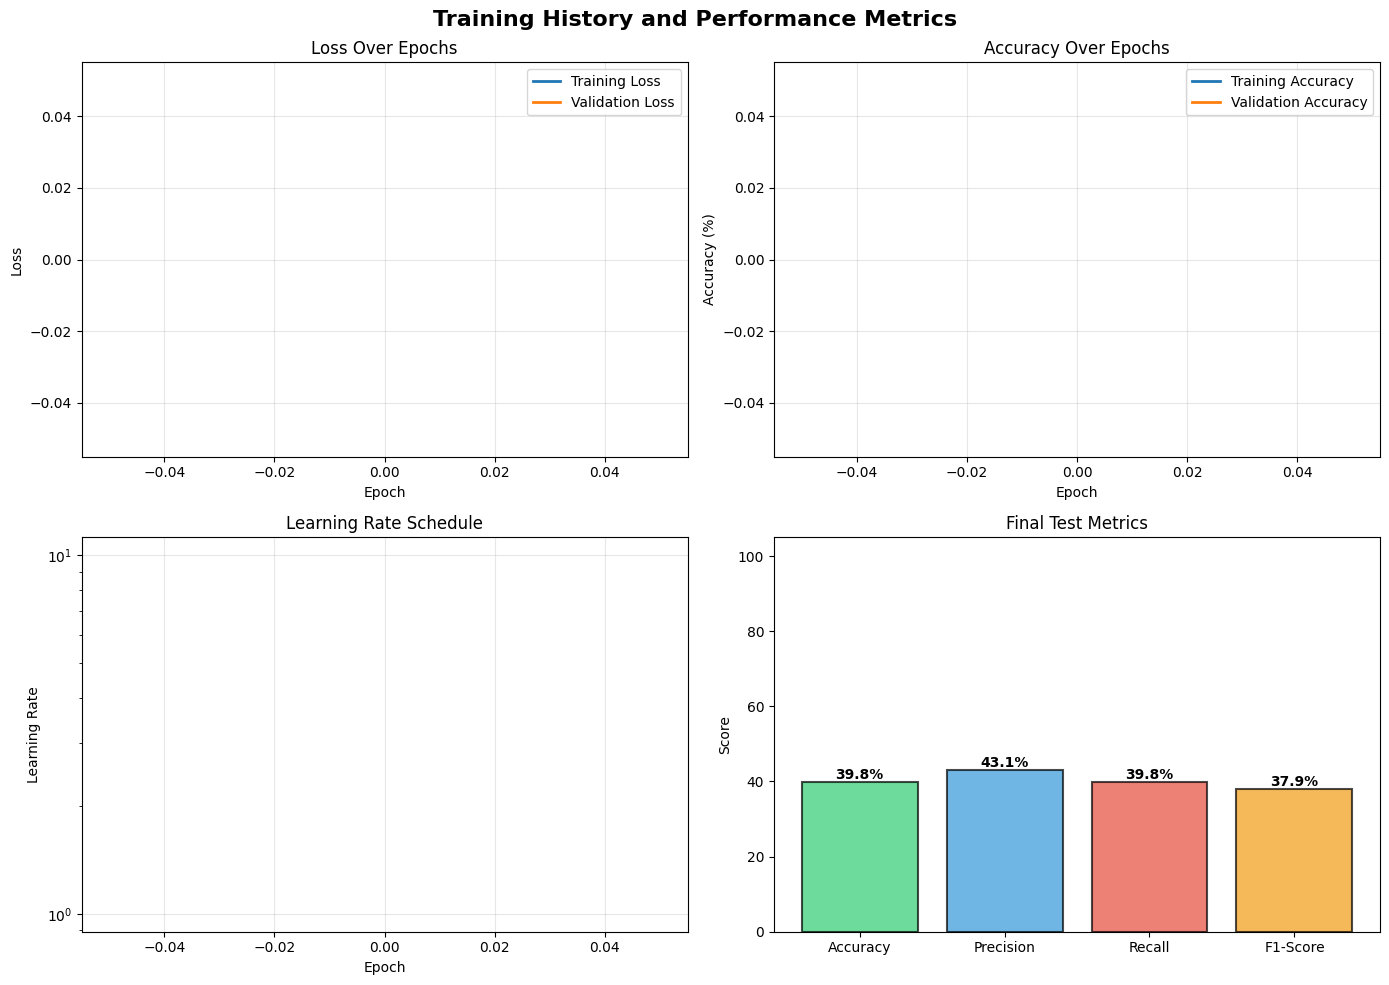


Training history plot saved as 'training_history.png'

PER-CLASS PERFORMANCE (Top 10 Classes)

Top 10 Best Performing Classes:
 1. edamame              - F1: 0.9108, Precision: 0.8664, Recall: 0.9600
 2. seaweed_salad        - F1: 0.7373, Precision: 0.8227, Recall: 0.6680
 3. pho                  - F1: 0.7177, Precision: 0.6243, Recall: 0.8440
 4. oysters              - F1: 0.6918, Precision: 0.7761, Recall: 0.6240
 5. spaghetti_carbonara  - F1: 0.6863, Precision: 0.7244, Recall: 0.6520
 6. macarons             - F1: 0.6792, Precision: 0.8192, Recall: 0.5800
 7. dumplings            - F1: 0.6701, Precision: 0.5873, Recall: 0.7800
 8. sashimi              - F1: 0.6677, Precision: 0.5425, Recall: 0.8680
 9. miso_soup            - F1: 0.6667, Precision: 0.6039, Recall: 0.7440
10. hot_and_sour_soup    - F1: 0.6617, Precision: 0.5259, Recall: 0.8920

Top 10 Worst Performing Classes:
 1. bread_pudding        - F1: 0.1555, Precision: 0.2358, Recall: 0.1160
 2. ceviche              - F1: 0.14

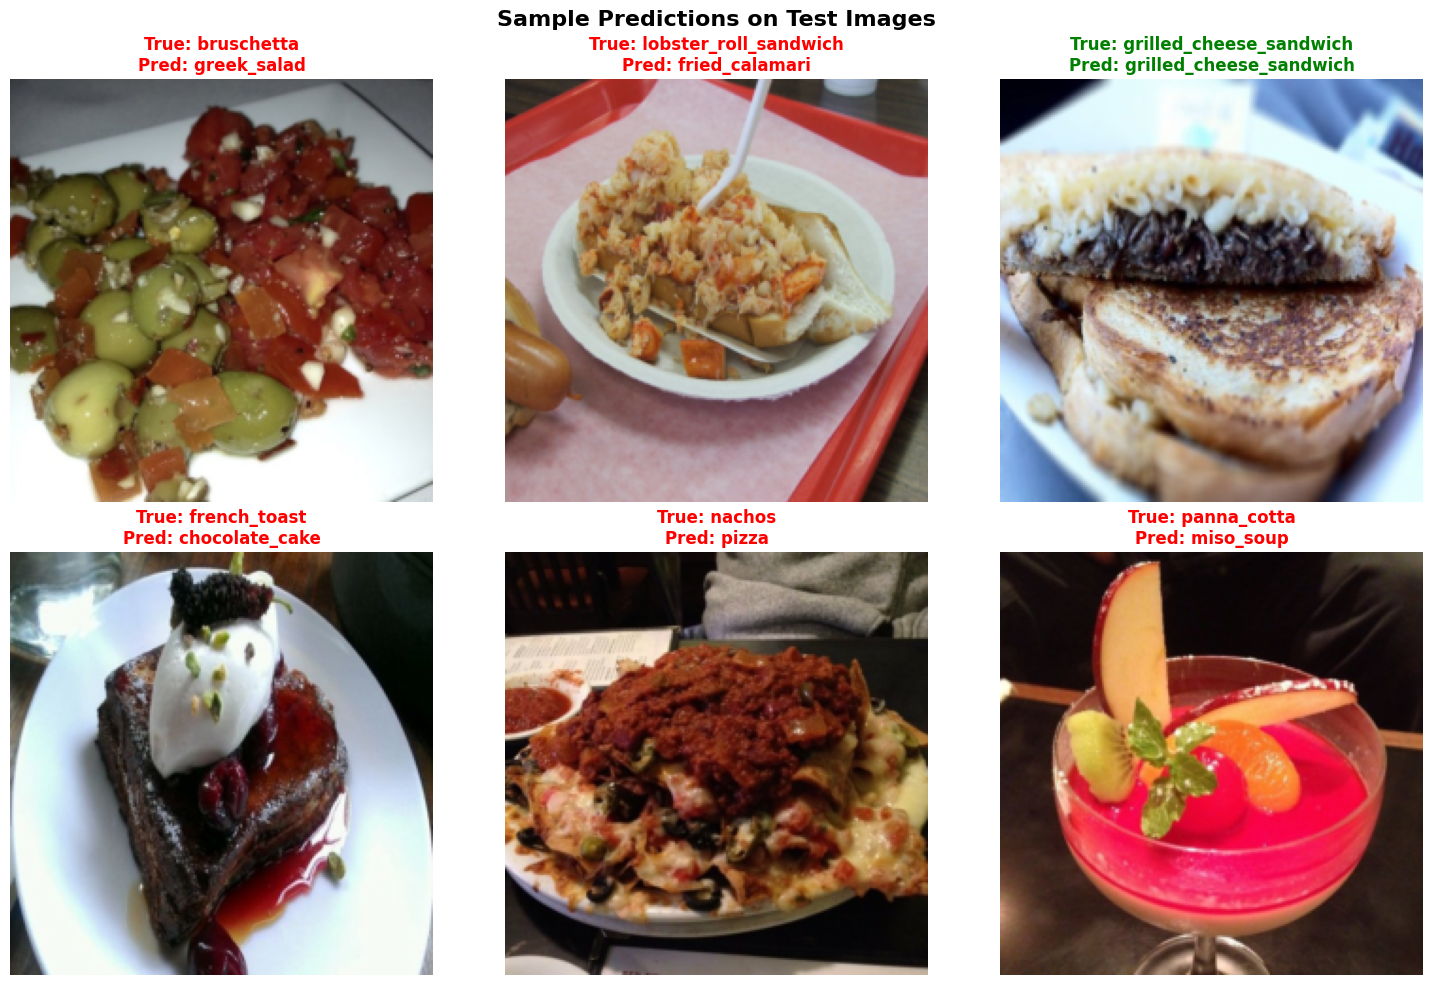

Sample predictions plot saved as 'sample_predictions.png'


In [26]:
print("=" * 80)
print("FINAL MODEL EVALUATION")
print("=" * 80)

# Get final predictions on test set
final_val_loss, final_val_acc, test_preds, test_labels = evaluate_model(
    model, test_loader, criterion, mode='Final Evaluation'
)

# Calculate additional metrics
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {final_val_acc:.2f}%")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  Loss:      {final_val_loss:.4f}")

# ==================== Training History Visualization ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training History and Performance Metrics', fontsize=16, fontweight='bold')

# Plot 1: Loss curves
axes[0, 0].plot(history['train_loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy Over Epochs')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
axes[1, 0].plot(history['learning_rates'], linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Metrics summary
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [final_val_acc, precision*100, recall*100, f1*100]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = axes[1, 1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Final Test Metrics')
axes[1, 1].set_ylim([0, 105])

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining history plot saved as 'training_history.png'")

# ==================== Per-Class Performance ====================
print("\n" + "=" * 80)
print("PER-CLASS PERFORMANCE (Top 10 Classes)")
print("=" * 80)

from sklearn.metrics import classification_report
class_names = train_dataset.classes
report = classification_report(test_labels, test_preds, target_names=class_names, 
                               digits=4, zero_division=0, output_dict=True)

# Sort by F1 score
sorted_classes = sorted([(name, report[name]['f1-score']) for name in class_names],
                        key=lambda x: x[1], reverse=True)

print(f"\nTop 10 Best Performing Classes:")
for i, (class_name, f1) in enumerate(sorted_classes[:10], 1):
    precision_c = report[class_name]['precision']
    recall_c = report[class_name]['recall']
    print(f"{i:2d}. {class_name:20s} - F1: {f1:.4f}, Precision: {precision_c:.4f}, Recall: {recall_c:.4f}")

print(f"\nTop 10 Worst Performing Classes:")
for i, (class_name, f1) in enumerate(sorted_classes[-10:], 1):
    precision_c = report[class_name]['precision']
    recall_c = report[class_name]['recall']
    print(f"{i:2d}. {class_name:20s} - F1: {f1:.4f}, Precision: {precision_c:.4f}, Recall: {recall_c:.4f}")

# ==================== Inference on Sample Images ====================
print("\n" + "=" * 80)
print("INFERENCE ON SAMPLE IMAGES")
print("=" * 80)

# Get a few test samples
model.eval()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Predictions on Test Images', fontsize=16, fontweight='bold')

sample_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)
images_batch, labels_batch = next(iter(sample_loader))

with torch.no_grad():
    outputs = model(images_batch.to(device))
    _, predictions = torch.max(outputs, 1)

# Denormalize images for display
inverse_transform = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])

for idx, (ax, image, true_label, pred_label) in enumerate(
    zip(axes.flat, images_batch, labels_batch, predictions)):
    
    # Denormalize and display
    image_np = inverse_transform(image).clamp(0, 1).numpy().transpose(1, 2, 0)
    ax.imshow(image_np)
    
    true_class = class_names[true_label.item()]
    pred_class = class_names[pred_label.item()]
    
    # Color code based on correctness
    if true_label.item() == pred_label.item():
        ax.set_title(f'True: {true_class}\nPred: {pred_class}', color='green', fontweight='bold')
    else:
        ax.set_title(f'True: {true_class}\nPred: {pred_class}', color='red', fontweight='bold')
    
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions plot saved as 'sample_predictions.png'")

**2. Your task:**

*  Find a picture from Google and download it.
*  Use the model you've just trained and evaluated, to predict the single image downloaded from Google.
*  Visualize the prediction, and print statistical results.


Predicted class for the input image: edamame


/var/folders/xb/tkf22bzj48n3bjkct_4hbx040000gn/T/ipykernel_13344/2714944269.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


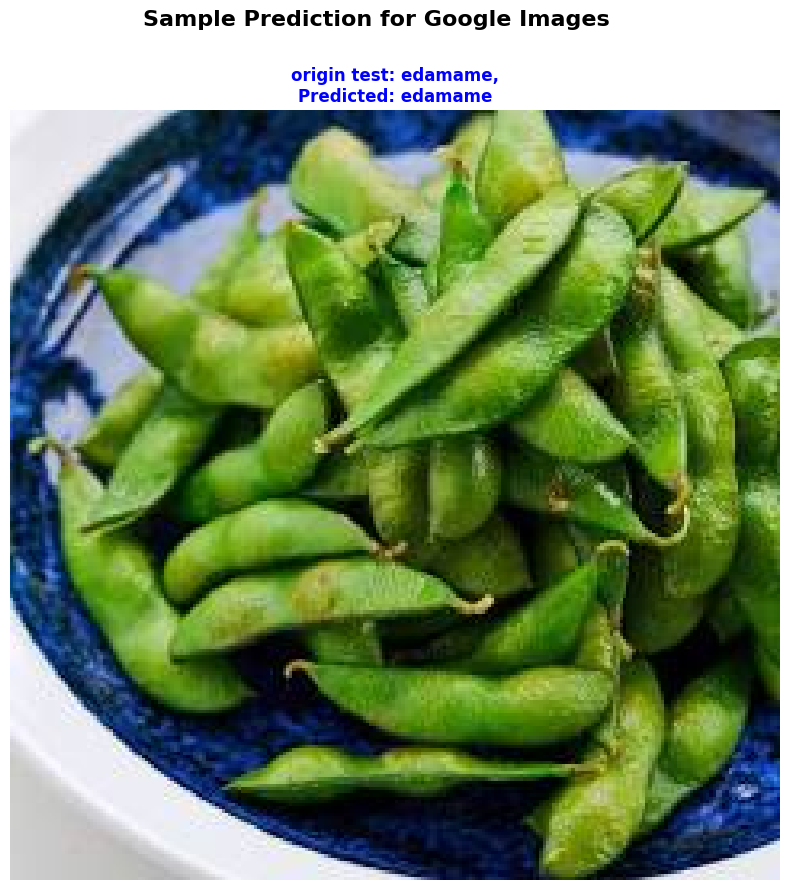

In [36]:
# --- TODO: Single Image Prediction ---
from PIL import Image
import matplotlib.pyplot as plt
test_image_path = Image.open("./data1/test_edamame.jpeg") # Replace with your image path
input_tensor = test_transforms(test_image_path)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)
    _, predicted_class = torch.max(output, 1)
predicted_label = class_names[predicted_class.item()]
print(f"\nPredicted class for the input image: {predicted_label}")
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
fig.suptitle('Sample Prediction for Google Images', fontsize=16, fontweight='bold')

axes.imshow(test_image_path)
axes.set_title(f'origin test: edamame,\nPredicted: {predicted_label}', color='blue', fontweight='bold')
axes.axis('off')
fig.show()


# ---------------------------------

**3. Summary of baseline model:** Phase I report

Please fill in the information required based on your baseline model

In [ ]:
report_template = """
================================================================================
PART 3 FINAL CHALLENGE - Phase I 
================================================================================

Step 3.1 to 3.4

================================================================================
SECTION 1: PROBLEM STATEMENT & APPROACH
================================================================================

1.1 Problem Statement
─────────────────────
Clearly state what problem you're solving:
  • Dataset: Food-101 (101 food categories, ~101k images, or subset)
  • Objective: [Classification / Detection / Segmentation]
  • Performance Goal: [Target accuracy]
  • Constraints: [Time, memory, etc.]

Example:
  "Build a CNN to classify food images into 101 categories with >80% accuracy
   using efficient training on GPU with early stopping."


1.2 Approach
────────────────────
Describe baseline approach (step 3.3):
  • Model architecture: [Type and complexity]
  • Training strategy: [Methods used]
  • Data handling: [Augmentation, preprocessing]
  • Evaluation: [Metrics]

Example:
  "We started with a custom CNN with 4 conv blocks (32→64→128→256 filters),
   trained with Adam optimizer, basic augmentation, and early stopping."


================================================================================
SECTION 2: IMPLEMENTATION DETAILS
================================================================================

2.1 Model Architecture
──────────────────────
Describe the baseline model in step 3.2:

a) Architecture Choice: [Custom CNN / Transfer Learning / Hybrid]
   
   If Custom CNN:
     • Number of layers: [N]
     • Filter progression: [Values]
     • Total parameters: [Number]
     • Key components: [BN, dropout, pooling, etc.]
   
   If Transfer Learning:
     • Base model: [ResNet18/ResNet50/EfficientNet/etc.]
     • Frozen layers: [Which ones]
     • Fine-tuned layers: [Which ones]
     • Custom head: [Architecture]
   
   Example:
     "Custom CNN with 4 convolutional blocks with batch normalization.
      Progressive filter expansion: 32→64→128→256.
      Global average pooling to reduce dimensions.
      Two fully connected layers (512, 256) with dropout.
      Total: 3.2M parameters."


2.2 Data Pipeline
─────────────────
Describe your data handling:

a) Data Augmentation:
   • Techniques used: [List techniques]
   • Why: [Justification]
   • Effect on training: [Observed impact]

   Example:
     "Applied random horizontal/vertical flips, rotation (15°),
      color jitter, and affine transformations.
      Increased generalization and reduced overfitting by ~5%."

b) Data Preprocessing:
   • Image size: [Resolution]
   • Normalization: [Method]
   • Train/test split: [Ratio]
   • Batch size: [Size]

   Example:
     "Resized all images to 224×224 (from 512×512).
      Normalized using ImageNet statistics (mean, std).
      Used 75/25 train/test split (75,750 / 25,250 samples).
      Batch size: 32 (balance between speed and memory)."


2.3 Training Configuration
──────────────────────────
Document your training setup:

a) Hyperparameters:
   • Learning rate: [Initial value]
   • Optimizer: [Type and settings]
   • Loss function: [Type]
   • Batch size: [Size]
   • Epochs: [Number]

   Example:
     "Adam optimizer with LR=0.001, no weight decay.
      CrossEntropyLoss for multi-class classification.
      Batch size: 32, max epochs: 30."

b) Regularization:
   • Dropout: [Values]
   • Weight decay: [Value]
   • Early stopping: [Patience]
   • Others: [List]

   Example:
     "Dropout: 0.5 in FC layers, 0.15 in conv blocks.
      Weight decay: 1e-4 (L2 regularization).
      Early stopping patience: 5 epochs.
      Gradient clipping: max_norm=1.0."

c) Learning Rate Schedule:
   • Type: [ReduceLROnPlateau / StepLR / Warmup / etc.]
   • Parameters: [Values]

   Example:
     "Used ReduceLROnPlateau: reduce LR by 0.5x when loss plateaus.
      Patience: 3 epochs, minimum LR: 1e-6."

================================================================================
"""

print(report_template)

# Save template
with open("FINAL_REPORT_1.txt", 'w') as f:
    f.write(report_template)

print("\n✓ Template saved to 'FINAL_REPORT_1.txt'")



PART 3 FINAL CHALLENGE - Phase I 

Step 3.1 to 3.4

SECTION 1: PROBLEM STATEMENT & APPROACH

1.1 Problem Statement
─────────────────────
Clearly state what problem you're solving:
  • Dataset: Food-101 (101 food categories, ~101k images, or subset)
  • Objective: [Classification / Detection / Segmentation]
  • Performance Goal: [Target accuracy]
  • Constraints: [Time, memory, etc.]

Example:
  "Build a CNN to classify food images into 101 categories with >80% accuracy
   using efficient training on GPU with early stopping."


1.2 Approach
────────────────────
Describe baseline approach (step 3.3):
  • Model architecture: [Type and complexity]
  • Training strategy: [Methods used]
  • Data handling: [Augmentation, preprocessing]
  • Evaluation: [Metrics]

Example:
  "We started with a custom CNN with 4 conv blocks (32→64→128→256 filters),
   trained with Adam optimizer, basic augmentation, and early stopping."


SECTION 2: IMPLEMENTATION DETAILS

2.1 Model Architecture
───────────────

### Part 3.5: Optimization (Optional)

We only provide hints about possible optimizations. You may try with your own way of fine-tuning hyperparameters, optimizing baseline models, or totally design a new model. It is ok to develop and compare your work with another baseline model, e.g. Vision Transformer.

**1.  Try `Transfer-Learning` with ResNet18 to accelerate the training process:** Transfer learning leverages knowledge from large-scale datasets (e.g., ImageNet)
to improve performance on smaller datasets.

ResNet18 already learned (from 1.2M ImageNet images):
* Layer 1: Edges, colors, basic patterns
* Layer 2: Textures and simple shapes
* Layer 3: Complex object parts
* Layer 4: Object categories (dogs, cars, trees, etc.)

Advantages:
* Significantly faster training (10x faster)
* Better accuracy (especially with limited data)
* Requires fewer epochs
* Less prone to overfitting

Disadvantages:
* Less interpretability
* Requires careful fine-tuning

In [ ]:
class FoodCNNTransfer(nn.Module):
    """
    Transfer Learning approach using pre-trained ResNet18.
    Much faster to train than training with the baseline.
    """
    def __init__(self, num_classes=101, pretrained=True):
        super(FoodCNNTransfer, self).__init__()
        
        # Load pre-trained ResNet18
        self.resnet = torchvision.models.resnet18(pretrained=pretrained)
        
        # Freeze early layers to preserve learned features
        for param in self.resnet.layer1.parameters():
            param.requires_grad = False
        for param in self.resnet.layer2.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

**2. Ensemble Methods**: Ensemble methods combine predictions from multiple models to achieve better accuracy and robustness.

Types:
*  Model Averaging: Combine predictions from multiple trained models
*  Voting: Majority voting among multiple models
*  Stacking: Train a meta-model on predictions from multiple models
*  Boosting: Sequential training with focus on misclassified samples


**3. Hyperparameter Optimization:** possible key hyperparameters to tune:

*  Learning Rate: [1e-4, 1e-3, 1e-2]
*  Batch Size: [16, 32, 64, 128]
*  Dropout Rate: [0.2, 0.3, 0.5, 0.7]
*  Weight Decay: [0, 1e-5, 1e-4, 1e-3]
*  Optimizer: [Adam, SGD, RMSprop]

**4. Vision Transformers (ViT)**: Vision Transformers apply the Transformer architecture to image tasks.

Advantages:
*  State-of-the-art performance
*  Better with large datasets
*  Efficient for high-resolution images
*  Good transfer learning properties

Disadvantages:
*  Requires more data for training from scratch
*  More computationally expensive
*  Slower inference

Pre-trained options:
*  ViT-Base: 86M parameters
*  ViT-Large: 304M parameters
*  DeiT: Distilled ViT (faster inference)

**Basic ViT Setup:**

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights

class FoodViT(nn.Module):
    def __init__(self, num_classes=101, pretrained=True):
        super(FoodViT, self).__init__()
        
        # Load pre-trained Vision Transformer
        if pretrained:
            self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        else:
            self.vit = vit_b_16(weights=None)
        
        # Replace classifier head
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.vit(x)

**ViT-Specific Data Transformations:**

In [ ]:
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### Now it's your turn! **Your Goal:** Get the **highest Test Accuracy** you can. This is a tough dataset, so >75% is a great start. >90% is excellent. Subset is good if you don't have access to GPU devices.

In [ ]:
# --- TODO: Your new model: dataloader, model design, training loop, validation process ---
 




# ---------------------------------

In [ ]:
report_template = """
================================================================================
PART 3 FINAL CHALLENGE - Phase II
================================================================================

Step 3.5

================================================================================
SECTION 1: OPTIMIZATION TECHNIQUES APPLIED
================================================================================

1.1 Data Augmentation Optimizations
───────────────────────────────────
Which augmentation techniques did you use?
  □ Basic (flips, rotation, jitter)
  □ Mixup
  □ CutMix
  □ RandAugment
  □ AutoAugment
  □ Other: ___________

Results:
  • Before: [Accuracy]
  • After: [Accuracy]
  • Improvement: [+X%]

Example:
  "✓ RandAugment applied (2 operations, magnitude 9)
   Before: 76%  →  After: 79%  (+3% improvement)"


1.2 Model Architecture Optimizations
────────────────────────────────────
Which architectural improvements did you implement?
  □ Standard CNN (baseline)
  □ Residual connections (skip connections)
  □ Depthwise separable convolutions
  □ Attention mechanisms (SE-blocks)
  □ Transfer learning
  □ Other: ___________

Results:
  • Architecture: [Description]
  • Parameters: [Count]
  • Speed: [Training time]
  • Accuracy: [Value]

Example:
  "✓ Residual connections added for gradient flow
   Parameters: 3.4M (baseline 3.2M)
   Training time: +10% per epoch
   Accuracy improvement: +2-3%"


1.3 Data Loading Optimizations
──────────────────────────────
Which data pipeline improvements did you use?
  □ Standard DataLoader
  □ Weighted random sampling
  □ Gradient accumulation
  □ Prefetch & pin memory
  □ Other: ___________

Results:
  • Technique: [Description]
  • Effect: [Impact]
  • Benefit: [Speed/accuracy/stability]

Example:
  "✓ Pin memory enabled for faster GPU transfer
   ✓ 4 num_workers for parallel data loading
   Effect: +15% training speed with no accuracy loss"


1.4 Training Optimizations
──────────────────────────
Which training improvements did you implement?
  □ Standard training
  □ Learning rate warmup
  □ Label smoothing
  □ Stochastic weight averaging
  □ Other: ___________

Results:
  • Technique: [Description]
  • Epochs saved: [Number]
  • Accuracy gain: [Value]

Example:
  "✓ Learning rate warmup (5 epochs)
   Convergence time: reduced by 8 epochs
   ✓ Label smoothing (smoothing=0.1)
   Accuracy: +1-2% improvement"

================================================================================
SECTION 2: IMPLEMENTATION DETAILS
================================================================================

2.1 Model Architecture
──────────────────────
Describe your final model:

a) Architecture Choice: [Custom CNN / Transfer Learning / Hybrid]
   
   If Custom CNN:
     • Number of layers: [N]
     • Filter progression: [Values]
     • Total parameters: [Number]
     • Key components: [BN, dropout, pooling, etc.]
   
   If Transfer Learning:
     • Base model: [ResNet18/ResNet50/EfficientNet/etc.]
     • Frozen layers: [Which ones]
     • Fine-tuned layers: [Which ones]
     • Custom head: [Architecture]
   
   Example:
     "Custom CNN with 4 convolutional blocks with batch normalization.
      Progressive filter expansion: 32→64→128→256.
      Global average pooling to reduce dimensions.
      Two fully connected layers (512, 256) with dropout.
      Total: 3.2M parameters."

b) Key Design Decisions:
   • Why did you choose this architecture?
   • How does it compare to alternatives?
   • What problems does it solve?

   Example:
     "Chose custom CNN to understand architectural principles.
      Added batch normalization for training stability.
      Used dropout to prevent overfitting on 101 classes.
      Global avg pooling more efficient than flatten."


2.2 Data Pipeline
─────────────────
Describe your data handling:

a) Data Augmentation:
   • Techniques used: [List techniques]
   • Why: [Justification]
   • Effect on training: [Observed impact]

   Example:
     "Applied random horizontal/vertical flips, rotation (15°),
      color jitter, and affine transformations.
      Increased generalization and reduced overfitting by ~5%."

b) Data Preprocessing:
   • Image size: [Resolution]
   • Normalization: [Method]
   • Train/test split: [Ratio]
   • Batch size: [Size]

   Example:
     "Resized all images to 224×224 (from 512×512).
      Normalized using ImageNet statistics (mean, std).
      Used 75/25 train/test split (75,750 / 25,250 samples).
      Batch size: 32 (balance between speed and memory)."


2.3 Training Configuration
──────────────────────────
Document your training setup:

a) Hyperparameters:
   • Learning rate: [Initial value]
   • Optimizer: [Type and settings]
   • Loss function: [Type]
   • Batch size: [Size]
   • Epochs: [Number]

   Example:
     "Adam optimizer with LR=0.001, no weight decay.
      CrossEntropyLoss for multi-class classification.
      Batch size: 32, max epochs: 30."

b) Regularization:
   • Dropout: [Values]
   • Weight decay: [Value]
   • Early stopping: [Patience]
   • Others: [List]

   Example:
     "Dropout: 0.5 in FC layers, 0.15 in conv blocks.
      Weight decay: 1e-4 (L2 regularization).
      Early stopping patience: 5 epochs.
      Gradient clipping: max_norm=1.0."

c) Learning Rate Schedule:
   • Type: [ReduceLROnPlateau / StepLR / Warmup / etc.]
   • Parameters: [Values]

   Example:
     "Used ReduceLROnPlateau: reduce LR by 0.5x when loss plateaus.
      Patience: 3 epochs, minimum LR: 1e-6."

================================================================================
SECTION 3: RESULTS & PERFORMANCE
================================================================================

3.1 Final Results
─────────────────
Report your final metrics:

Test Set Performance:
  • Accuracy: [X.XX%]
  • Precision: [X.XXXX]
  • Recall: [X.XXXX]
  • F1-Score: [X.XXXX]
  • Loss: [X.XXXX]

Example:
  • Accuracy: 80.32%
  • Precision: 0.8015
  • Recall: 0.8032
  • F1-Score: 0.8021
  • Loss: 0.6842


3.2 Training Progress
─────────────────────
Describe how training evolved:

Epoch-wise breakdown:
  • Early epochs (1-5): [Observations]
  • Mid epochs (6-15): [Observations]
  • Late epochs (16+): [Observations]

Example:
  "Early: Loss decreased rapidly, good gradient flow
   Mid: Validation accuracy plateaued around 78%
   Late: Fine-tuning phase, +2% improvement with warmup"


3.3 Comparison to Baselines
─────────────────────────────
How does your final model compare?

| Model | Accuracy | Parameters | Time | Complexity |
|-------|----------|-----------|------|-----------|
| Baseline CNN | X% | XM | Xh | Low |
| Your Final | Y% | YM | Yh | Medium |
| Transfer Learning (if tried) | Z% | ZM | Zh | Low |

Example:
| Baseline CNN | 75% | 3.2M | 1.0h | Low |
| Final Model | 80% | 3.4M | 1.1h | Medium |
| ResNet18 (bonus) | 86% | 11.2M | 0.3h | Low |


3.4 Per-Class Analysis
──────────────────────
Top and bottom performing classes:

Best performing classes:
  1. [Class name]: [Accuracy]
  2. [Class name]: [Accuracy]
  3. [Class name]: [Accuracy]

Worst performing classes:
  1. [Class name]: [Accuracy]
  2. [Class name]: [Accuracy]
  3. [Class name]: [Accuracy]

Why?
  • [Analysis of good performance]
  • [Analysis of poor performance]

Example:
Best:
  1. Apple pie: 94% (distinct appearance)
  2. Donut: 91% (varied presentations)
  3. Burger: 89% (consistent structure)

Worst:
  1. Falafel: 65% (similar to other fried foods)
  2. Cannoli: 68% (confusion with similar pastries)
  3. Huevos rancheros: 71% (variant forms)

Why: Similar-looking foods and variant presentations cause confusion.

================================================================================
"""

print(report_template)

# Save template
with open("FINAL_REPORT_2.txt", 'w') as f:
    f.write(report_template)

print("\n✓ Template saved to 'FINAL_REPORT_2.txt'")


In [ ]:
report_template = """
================================================================================
PART 3 FINAL CHALLENGE - Phase III
================================================================================

INSIGHTS: What Worked Well?
================================================================================

Your answer:

────────────────────────────

Examples:
Three techniques had the most impact:

1. Batch Normalization (Critical)
   • Removing BN dropped accuracy by 12%!
   • Stabilized training and enabled deeper networks
   • Should be standard in all CNN designs
   • Insight: Modern CNNs are critically dependent on BN

2. Learning Rate Scheduling
   • ReduceLROnPlateau adapted to learning dynamics
   • Automatically reduced LR when loss plateaued
   • Prevented overfitting and improved convergence
   • Insight: Adaptive LR > fixed LR

3. Data Augmentation (RandAugment)
   • +3% improvement with zero overhead
   • Simple one-line change to code
   • More robust than manual augmentation
   • Insight: Automated augmentation policies are powerful

================================================================================
"""

print(report_template)

# Save template
with open("FINAL_REPORT_3.txt", 'w') as f:
    f.write(report_template)

print("\n✓ Template saved to 'FINAL_REPORT_3.txt'")
